## Predicting if a loan will be paid off or not
** Can we build a machine learning model that can accurately predict if a borrower will pay off their loan on time or not? **

The objective is to get a model that has:

* **TPR > 70%** (TPR: true positive rate - proportion of positives that are correctly identified)
* **FPR < 7%**  (FPR: false positive rate - proportion of positives that are incorrect)

In other words, we want to predicts as many 1s as possible (> 70%) making the fewest mistakes as possible (< 0.7%) on those predictions.

### INDEX

1. INTRODUCTION
2. PREPARE DATA
3. MODELS
3.1 FEATURE SELECTION/ OVERSAMPLING
3.2 LG
3.3 RF



### INTRODUCTION

Credit has played a key role in the economy for centuries and some form of credit has existed since the beginning of commerce. We'll be working with financial lending data from Lending Club. Lending Club is a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. You can read more about their marketplace here.

Each borrower fills out a comprehensive application, providing their past financial history, the reason for the loan, and more. Lending Club evaluates each borrower's credit score using past historical data (and their own data science process!) and assigns an interest rate to the borrower. The interest rate is the percent in addition to the requested loan amount the borrower has to pay back. You can read more about the interest rate that Lending Club assigns here. Lending Club also tries to verify each piece of information the borrower provides but it can't always verify all of the information (usually for regulation reasons).
A higher interest rate means that the borrower is riskier and more unlikely to pay back the loan while a lower interest rate means that the borrower has a good credit history is more likely to pay back the loan. The interest rates range from 5.32% all the way to 30.99% and each borrower is given a grade according to the interest rate they were assigned. If the borrower accepts the interest rate, then the loan is listed on the Lending Club marketplace.

Investors are primarily interested in receiving a return on their investments. Approved loans are listed on the Lending Club website, where qualified investors can browse recently approved loans, the borrower's credit score, the purpose for the loan, and other information from the application. Once they're ready to back a loan, they select the amount of money they want to fund. Once a loan's requested amount is fully funded, the borrower receives the money they requested minus the origination fee that Lending Club charges.

The borrower then makes monthly payments back to Lending Club either over 36 months or over 60 months. Lending Club redistributes these payments to the investors. This means that investors don't have to wait until the full amount is paid off to start to see money back. If a loan is fully paid off on time, the investors make a return which corresponds to the interest rate the borrower had to pay in addition the requested amount. Many loans aren't completely paid off on time, however, and some borrowers default on the loan.

While Lending Club has to be extremely savvy and rigorous with their credit modelling, investors on Lending Club need to be equally as savvy about determining which loans are more likely to be paid off. While at first, you may wonder why investors would put money into anything but low interest loans. The incentive investors have to back higher interest loans is, well, the higher interest! If investors believe the borrower can pay back the loan, even if he or she has a weak financial history, then investors can make more money through the larger additional amount the borrower has to pay.

Most investors use a portfolio strategy to invest small amounts in many loans, with healthy mixes of low, medium, and interest loans. In this project, we'll focus on the mindset of a conservative investor who only wants to invest in the loans that have a good chance of being paid off on time. To do that, we'll need to first understand the features in the dataset and then experiment with building machine learning models that reliably predict if a loan will be paid off or not.

Data dictionary: https://docs.google.com/spreadsheets/d/191B2yJ4H1ZPXq0_ByhUgWMFZOYem5jFz0Y3by_7YBY4/edit#gid=2081333097

### START

First Let's load the data and do some quick checks:

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_predict
from sklearn import pipeline, grid_search
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

In [2]:
loan_df = pd.read_csv(".\\data\\LoanStats3a.csv")

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loan_df.shape

(42538, 111)

In [4]:
loan_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


Let's start getting rid of useless columns, by useless columns I mean columns that:

* leak information from the future (after the loan has already been funded)
* don't affect a borrower's ability to pay back a loan (e.g. a randomly generated ID value by Lending Club)
* formatted poorly and need to be cleaned up
* require more data or a lot of processing to turn into a useful feature
* contain redundant information

removing the desc column (which contains a long text explanation for each loan) and removing the url column (which contains a link to each loan on Lending Club which can only be accessed with an investor account)

In [5]:
loan_df = loan_df.drop(['desc', 'url'],axis=1)

removing duplicates if any

In [6]:
print(loan_df.shape)
print("Removing duplicates if any ...")
loan_df.drop_duplicates()
print(loan_df.shape)

(42538, 109)
Removing duplicates if any ...
(42538, 109)


Dropping columns that are reduntant or leak data

In [7]:
loan_df.drop(['id','member_id','funded_amnt','funded_amnt_inv','grade','sub_grade',
              'issue_d','zip_code','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
              'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee',
              'last_pymnt_d','last_pymnt_amnt'], axis=1,inplace=True)

In [8]:
loan_df.shape

(42538, 90)

Dropping columns with more than 90% missing values

In [9]:
# check for columns with 90% of missing values
percent = 0.9
over_ninety_percernt_ma = loan_df.isnull().sum()[loan_df.isnull().sum() /  loan_df.shape[0] > percent].index.tolist()
loan_df.drop(over_ninety_percernt_ma, axis=1,inplace=True)
over_ninety_percernt_ma.sort()
over_ninety_percernt_ma

['acc_open_past_24mths',
 'all_util',
 'annual_inc_joint',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'dti_joint',
 'il_util',
 'inq_fi',
 'inq_last_12m',
 'max_bal_bc',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_rcnt_il',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'next_pymnt_d',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'open_acc_6m',
 'open_il_12m',
 'open_il_24m',
 'open_il_6m',
 'open_rv_12m',
 'open_rv_24m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'tot_coll_amt',
 'tot_cur_bal',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bal_il',
 'total_bc_l

In [10]:
loan_df.shape

(42538, 34)

In [11]:
loan_df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'pymnt_plan', 'purpose', 'title', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

Now let's focus on the target column.

Since we're interesting in being able to predict which of these 2 values a loan will fall under, we can treat the problem as a binary classification one. Let's remove all the loans that don't contain either Fully Paid and Charged Off as the loan's status and then transform the Fully Paid values to 1 for the positive case and the Charged Off values to 0 for the negative case

In [12]:
#target coluumn
loan_df.loan_status.value_counts()

Fully Paid                                             33586
Charged Off                                             5653
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Current                                                  513
In Grace Period                                           16
Late (31-120 days)                                        12
Late (16-30 days)                                          5
Default                                                    1
Name: loan_status, dtype: int64

In [13]:
# keep "Full Paid" and "Charged Off"
loan_df = loan_df[loan_df["loan_status"].isin(["Fully Paid","Charged Off"])]
mapping_dict = {
    "loan_status": {
        "Fully Paid": 1,
        "Charged Off": 0,
    }
}
loan_df = loan_df.replace(mapping_dict)
loan_df.loan_status.value_counts()

1    33586
0     5653
Name: loan_status, dtype: int64

let's also get rid of columns that only has 1 unique value (that won't give our model any info)

In [14]:
# let's check for columns with just one value
cols_to_drop = []
for col in loan_df.columns:
    if len(loan_df[col].dropna().unique()) == 1:
           cols_to_drop.append(col)

print(cols_to_drop)
loan_df.drop(cols_to_drop, axis=1, inplace=True)    

['initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens']


In [15]:
# this one has only 1 value for 1 ....
print(loan_df.pymnt_plan.value_counts())
loan_df.drop('pymnt_plan', axis=1, inplace=True) # get rid of it

n    39238
y        1
Name: pymnt_plan, dtype: int64


Now we are going to work on the features that still have missing values, we can:

* remove rows
* set new value (other, min, max, mean, etc ..)
* regress new value based on other columns
* ...


In [16]:
loan_df.isnull().sum()

loan_amnt                     0
term                          0
int_rate                      0
installment                   0
emp_title                  2426
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
loan_status                   0
purpose                       0
title                        10
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
mths_since_last_delinq    25352
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                   50
total_acc                     0
last_credit_pull_d            2
pub_rec_bankruptcies        697
dtype: int64

After checking the variables let's manage missing values, we'll:

* remove column emp_title. There are too many missing values and it relates with 'title'
* Fill missing values with the median to 'mths_since_last_delinq'
* Remove rows with missing values on pandas data frame

In [17]:
# fix missing values in columns
loan_df.drop('emp_title', axis=1, inplace=True)
#loan_df.mths_since_last_delinq = loan_df.mths_since_last_delinq.fillna(loan_df.mths_since_last_delinq.median())
#loan_df.pub_rec_bankruptcies = loan_df.pub_rec_bankruptcies.fillna(0)
# remove rows with missing values
loan_df.dropna(axis=0, inplace=True)
# check missing values again (should be none)
loan_df.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
emp_length                0
home_ownership            0
annual_inc                0
verification_status       0
loan_status               0
purpose                   0
title                     0
addr_state                0
dti                       0
delinq_2yrs               0
earliest_cr_line          0
inq_last_6mths            0
mths_since_last_delinq    0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util                0
total_acc                 0
last_credit_pull_d        0
pub_rec_bankruptcies      0
dtype: int64

Let's focus now on the text columns. We need to convert them to numerical 

In [18]:
print(loan_df.dtypes.value_counts())
# show an example of object columns
loan_df.select_dtypes(include=['object']).iloc[0]

float64    12
object     11
int64       1
dtype: int64


term                         36 months
int_rate                        13.49%
emp_length                   10+ years
home_ownership                    RENT
verification_status    Source Verified
purpose                          other
title                         personel
addr_state                          CA
earliest_cr_line              Feb-1996
revol_util                         21%
last_credit_pull_d            Apr-2016
Name: 3, dtype: object

Let's first convert revol_util and int_rate to numerical values

In [19]:
loan_df.int_rate = loan_df.int_rate.map(lambda x: float(x[:-1]))
loan_df.revol_util = loan_df.revol_util.map(lambda x: float(x[:-1]))
loan_df.term = loan_df.term.map(lambda x: int(x.split()[0]))

In [20]:
# term
loan_df.emp_length.value_counts()
mapping_dict = {'emp_length':{
        '10+ years':'10',
        '< 1 year':'0',
        'n/a':'-1'
    }
}
loan_df = loan_df.replace(mapping_dict)
loan_df.emp_length = loan_df.emp_length.map(lambda x: int(x.split()[0]))
loan_df.emp_length.value_counts()

 10    3162
 2     1402
 3     1359
 0     1337
 4     1169
 5     1080
 1     1021
 6      744
 7      630
 8      528
 9      407
-1      340
Name: emp_length, dtype: int64

To work with the column title we are going to:

* Set to lowercase
* Tokenize
* Remove stopwords 
* Snowball stemmer
* tf-idf
* SVD (n=5)
* Add the 5 resulting columns to our data frame

In [28]:
import nltk
lemma = nltk.wordnet.WordNetLemmatizer()
lemma.lemmatize('leaves')


'leaf'

In [29]:
tokenizer = RegexpTokenizer(r'\w+')
title_tokens = loan_df['title'].map(lambda x: tokenizer.tokenize(x.lower()))
title_tokens_filter = title_tokens.map(lambda x: [word for word in x if word not in stopwords.words('english')])
title_tokens_filter = title_tokens_filter.map(lambda x: ['empty'] if x == [] else x)
#sbst = SnowballStemmer(language='english')
title_tokens_filter_stem = title_tokens_filter.map(lambda x: lemma.lemmatize((' ').join(x)))

#tfidf
tfidf = TfidfVectorizer(ngram_range=(1, 3), stop_words='english')
tfidf_values = tfidf.fit_transform(title_tokens_filter_stem)
tsvd = TruncatedSVD(n_components=15, random_state = 1)
tfidf_values_truncatedSVD = tsvd.fit_transform(tfidf_values)

#drop original title column
loan_df.drop('title',1, inplace=True)

for earliest_cr_line, last_credit_pull_d we want to get month and year in numbers, I create float that will tell me year and month (year + month/13)

In [30]:
# convert to date
earliest_cr_line = pd.to_datetime(loan_df.earliest_cr_line)
last_credit_pull_d = pd.to_datetime(loan_df.last_credit_pull_d)
# extract month and year
earliest_cr_line_year = earliest_cr_line.map(lambda x: x.year)
earliest_cr_line_month = earliest_cr_line.map(lambda x: x.month)
last_credit_pull_d_year = last_credit_pull_d.map(lambda x: x.year)
last_credit_pull_d_month = last_credit_pull_d.map(lambda x: x.month)
# create float with year + month/13
loan_df.earliest_cr_line = earliest_cr_line_year + earliest_cr_line_month/13
loan_df.last_credit_pull_d = last_credit_pull_d_year + last_credit_pull_d_month/13
loan_df['earliest_cr_line_month'] = earliest_cr_line_month
loan_df['last_credit_pull_d_month'] = last_credit_pull_d_month

purpose, verification_status, home_ownership, and addr_state as dummies because they don't have many values (maybe we could skip state)

In [31]:
loan_df = pd.concat([loan_df, pd.get_dummies(loan_df.purpose)], axis=1)
loan_df = pd.concat([loan_df, pd.get_dummies(loan_df.verification_status)], axis=1)
loan_df = pd.concat([loan_df, pd.get_dummies(loan_df.home_ownership)], axis=1)
loan_df = pd.concat([loan_df, pd.get_dummies(loan_df.addr_state)], axis=1)
loan_df = pd.concat([loan_df, pd.get_dummies(loan_df.earliest_cr_line_month)], axis=1)
loan_df = pd.concat([loan_df, pd.get_dummies(loan_df.last_credit_pull_d_month)], axis=1)
loan_df = pd.concat([loan_df.reset_index(drop=True), pd.DataFrame(tfidf_values_truncatedSVD)], axis=1)

loan_df.drop(['purpose','verification_status','home_ownership','addr_state',
              'mths_since_last_delinq','last_credit_pull_d_month','earliest_cr_line_month'], axis=1, inplace=True)

Let's save the processed data frame to apply our model

In [32]:
# save processed data
loan_df.to_csv(".\\data_processed\loans.csv",index=False,encoding='utf8')

Now we have data ready to apply some machine learning models. Or objective is to achive TPR > 50% adn FPR < 7%.
We'll try logistic regression and random forest. On both models we'll use the param weights to account for class imbalace.

## MODELS

Remember that our objective is to get TPR > 70% and FPR < 7% for both LR and RF

In [82]:
#penalty = {0: 4,1: 1}

lr = LogisticRegression(class_weight='balanced', random_state = 3, penalty='l2', C=1)
rf = RandomForestClassifier(n_estimators=400, min_samples_leaf=400, class_weight='balanced',random_state=3)
selection_param = 0.0003

## FEATURE SELECTION (RF) / OVERSAMPLING

In [83]:
loan_df = pd.read_csv(".\\data_processed\loans.csv")
#loan_df_0 = loan_df[loan_df["loan_status"]==0]
#loan_df = pd.concat([loan_df,loan_df_0],ignore_index=True)
#loan_df = pd.concat([loan_df,loan_df_0],ignore_index=True)
#loan_df = pd.concat([loan_df,loan_df_0],ignore_index=True)
#loan_df = pd.concat([loan_df,loan_df_0],ignore_index=True)
#loan_df = pd.concat([loan_df,loan_df_0],ignore_index=True)
#loan_df = pd.concat([loan_df,loan_df_0],ignore_index=True)

features = loan_df.drop("loan_status", 1)
target = loan_df.loan_status

rfsel = RandomForestClassifier(n_estimators=500, min_samples_leaf=200, class_weight='balanced',random_state=2)
rfsel.fit(features, target)

features_lb = sorted(zip(map(lambda x: round(x, 4), rfsel.feature_importances_), features.columns), reverse=True, key=lambda pair: pair[0])
columns = [features_lb[i][1] for i in range(0,10)] 


features = features[[i[1] for i in features_lb if i[0]>selection_param]]
sd = StandardScaler()
features = sd.fit_transform(features)

[i for i in features_lb if i[0]>selection_param]

[(0.41310000000000002, 'last_credit_pull_d'),
 (0.32529999999999998, '9.1'),
 (0.037499999999999999, 'int_rate'),
 (0.035700000000000003, 'term'),
 (0.0161, '7.1'),
 (0.015900000000000001, 'annual_inc'),
 (0.015800000000000002, '3.1'),
 (0.014500000000000001, '4.1'),
 (0.013599999999999999, '8.1'),
 (0.010500000000000001, '6.1'),
 (0.0091000000000000004, '2.1'),
 (0.0088000000000000005, '5.1'),
 (0.0074999999999999997, '12.1'),
 (0.0071999999999999998, '11.1'),
 (0.0053, '1.1'),
 (0.0044000000000000003, '10.1'),
 (0.0038, 'revol_util'),
 (0.0038, '7.2'),
 (0.0035000000000000001, 'loan_amnt'),
 (0.0028999999999999998, 'earliest_cr_line'),
 (0.0028, '9.2'),
 (0.0027000000000000001, '3.2'),
 (0.0025999999999999999, 'revol_bal'),
 (0.0025000000000000001, '1.2'),
 (0.0023999999999999998, 'installment'),
 (0.0023, 'inq_last_6mths'),
 (0.0023, 'total_acc'),
 (0.002, 'dti'),
 (0.0018, 'open_acc'),
 (0.0016999999999999999, '8.2'),
 (0.0016000000000000001, 'small_business'),
 (0.0016000000000000

## LOGISTIC REGRESSION -  TRAIN-TEST 

TPR:  0.688032272523532
FPR:  0.07901234567901234
CONFUSION MATRIX:
TN:  373    FP:  32
FN:  696    TP:  1535


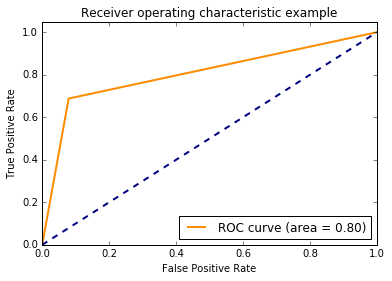

In [84]:
X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target,test_size=0.20)

lr.fit(X_train, y_train)

predictions = lr.predict(X_test)
predictions = pd.Series(predictions)

tn = len(predictions[(predictions == 0) & (y_test.values==0)])  
tp = len(predictions[(predictions == 1) & (y_test.values==1)]) 
fn = len(predictions[(predictions == 0) & (y_test.values==1)])  
fp = len(predictions[(predictions == 1) & (y_test.values==0)]) 
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)

#print(lr.coef_)
print('TPR: ',tpr)
print('FPR: ',fpr)
fprpoints, tprpoints, thresholds = roc_curve(y_test, predictions)
print('CONFUSION MATRIX:')
cm = confusion_matrix(y_test,predictions)
print('TN: ',cm[0,0], '   FP: ',cm[0,1])
print('FN: ',cm[1,0], '   TP: ',cm[1,1])
plt.figure()
lw = 2
plt.plot(fprpoints, tprpoints, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc(fprpoints,tprpoints))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## LOGISTIC REGRESSION - CV


TPR:  0.7022859704168535
FPR:  0.07905138339920949
CONFUSION MATRIX:
TN:  1864    FP:  160
FN:  3321    TP:  7834


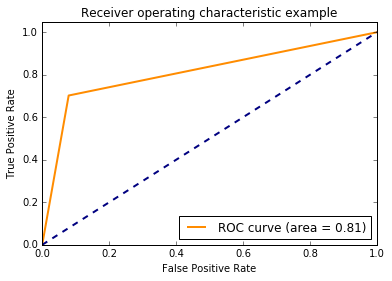

In [85]:
kf = KFold(features.shape[0], random_state=1)

predictions = cross_val_predict(lr, features, target,cv=kf)
predictions = pd.Series(predictions)

tn = len(predictions[(predictions == 0) & (target==0)])  
tp = len(predictions[(predictions == 1) & (target==1)]) 
fn = len(predictions[(predictions == 0) & (target==1)])  
fp = len(predictions[(predictions == 1) & (target==0)]) 
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)

print()
print('TPR: ',tpr)
print('FPR: ',fpr)
fprpoints, tprpoints, thresholds = roc_curve(target, predictions)
print('CONFUSION MATRIX:')
cm = confusion_matrix(target,predictions)
print('TN: ',cm[0,0], '   FP: ',cm[0,1])
print('FN: ',cm[1,0], '   TP: ',cm[1,1])
plt.figure()
lw = 2
plt.plot(fprpoints, tprpoints, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc(fprpoints,tprpoints))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## RANDOM FOREST -  TRAIN-TEST 

TPR:  0.7140295831465711
FPR:  0.06172839506172839
CONFUSION MATRIX:
TN:  380    FP:  25
FN:  638    TP:  1593


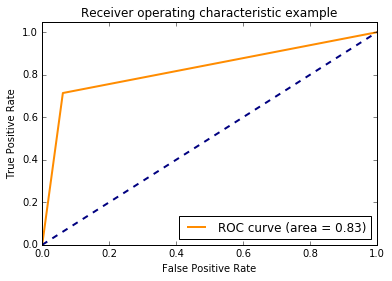

In [86]:
X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target,test_size=0.20)

rf.fit(X_train, y_train)

predictions = rf.predict(X_test)
predictions = pd.Series(predictions)

tn = len(predictions[(predictions == 0) & (y_test.values==0)])  
tp = len(predictions[(predictions == 1) & (y_test.values==1)]) 
fn = len(predictions[(predictions == 0) & (y_test.values==1)])  
fp = len(predictions[(predictions == 1) & (y_test.values==0)]) 
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)

print('TPR: ',tpr)
print('FPR: ',fpr)
fprpoints, tprpoints, thresholds = roc_curve(y_test, predictions)
print('CONFUSION MATRIX:')
cm = confusion_matrix(y_test,predictions)
print('TN: ',cm[0,0], '   FP: ',cm[0,1])
print('FN: ',cm[1,0], '   TP: ',cm[1,1])
plt.figure()
lw = 2
plt.plot(fprpoints, tprpoints, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc(fprpoints,tprpoints))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## RANDOM FOREST -  CV

TPR:  0.7076647243388615
FPR:  0.04693675889328063
CONFUSION MATRIX:
TN:  1929    FP:  95
FN:  3261    TP:  7894


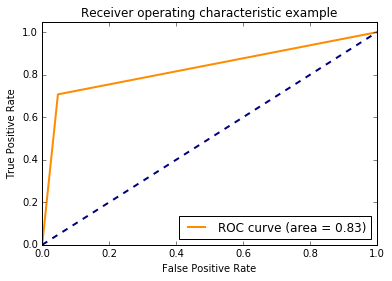

In [87]:
kf = KFold(features.shape[0], random_state=1)

predictions = cross_val_predict(rf, features, target,cv=kf)
predictions = pd.Series(predictions)

tn = len(predictions[(predictions == 0) & (target==0)])  
tp = len(predictions[(predictions == 1) & (target==1)]) 
fn = len(predictions[(predictions == 0) & (target==1)])  
fp = len(predictions[(predictions == 1) & (target==0)]) 

fpr = fp / (fp + tn)
tpr = tp / (tp + fn)

print('TPR: ',tpr)
print('FPR: ',fpr)
fprpoints, tprpoints, thresholds = roc_curve(target, predictions)
print('CONFUSION MATRIX:')
cm = confusion_matrix(target,predictions)
print('TN: ',cm[0,0], '   FP: ',cm[0,1])
print('FN: ',cm[1,0], '   TP: ',cm[1,1])
plt.figure()
lw = 2
plt.plot(fprpoints, tprpoints, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc(fprpoints,tprpoints))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## CONCLUSIONS

We were able to get TPR > 70% and FPR < 7% for both RF and LR (aprox)

## TO DO NEXT

* Understand how each feature affect the output (check LG coefficients). 
